# Question A3

Find the optimal number of hidden neurons for first hidden layer of the 4-layer network (3 hidden layers, output layer) designed in Question 1 and 2

#### Plot the mean cross-validation accuracies on the final epoch for different numbers of hidden-layer neurons using a scatter plot. Limit the search space of the number of neurons to {64, 128, 256}. Continue using 5-fold cross validation on training dataset. Select the optimal number of neurons for the hidden layer. State the rationale for your selection.

This might take a while to run, approximately 20 - 30 min, so plan your time carefully.

1. Firstly, we import relevant libraries.

In [1]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from common_utils import set_seed

# setting seed
set_seed()

2. To reduce repeated code, place your

- network (MLP defined in QA1)
- torch datasets (CustomDataset defined in QA1)
- loss function (loss_fn defined in QA1)

in a separate file called **common_utils.py**

Import them into this file. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked.

The following code cell will not be marked.

In [2]:
# YOUR CODE HERE
from common_utils import MLP, CustomDataset, loss_fn, split_dataset, preprocess_dataset, EarlyStopper

# load simplified.csv into df
df = pd.read_csv('simplified.csv')
df['label'] = df['filename'].str.split('_').str[-2]
df['label'].value_counts()

label_encoder = preprocessing.LabelEncoder()

df['label'] = label_encoder.fit_transform(df['label'])
X = df.drop(['filename', 'label'], axis=1)
y = df['label'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

3. Perform hyperparameter tuning for the different neurons with 5-fold cross validation.

In [3]:
def train_loop(dataloader, model, losss_fn, optimizer):
    """
    Used to perform training for each epoch.
    Returns train loss & accuracy for each epoch.
    """
    size = len(dataloader.dataset)
    train_loss, acc = 0, 0
    for batch, (x, y) in enumerate(dataloader):
        pred = model(x)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        acc += (pred.argmax(1) == y).type(torch.float).sum().item()
    train_loss /= size
    acc /= size
    return train_loss, acc


def test_loop(dataloader, model, loss_fn):
    """
    Used to perform testing for each epoch.
    Returns test loss and accuracy for each epoch.
    """
    size = len(dataloader.dataset)
    test_loss, acc = 0, 0
    with torch.no_grad():
        for x, y, in dataloader:
            pred = model(x)
            test_loss += loss_fn(pred, y).item()
            acc += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= size
    acc /= size
    return test_loss, acc


def train(model, X_train_scaled, y_train2, X_val_scaled, y_val2, batch_size):
    """
    Used to do the mini-batch training for each fold.
    returns a list of:
    - training accuracy for current fold.
    - training loss for current fold.
    - testing accuracy for current fold.
    - testing loss for current fold.
    - time taken to train each epoch for current fold.
    """
    # YOUR CODE HERE
    lr = 0.001
    no_epochs = 100

    train_dataloader = dataloader_maker(X_train_scaled, y_train2, batch_size, True)
    test_dataloader = dataloader_maker(X_val_scaled, y_val2, batch_size, True)
    # loss_fn is already imported from common utils
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    early_stopper = EarlyStopper(patience=3, min_delta=0.00005)

    train_accuracies, train_losses, test_accuracies, test_losses, times = [], [], [], [], []
    for epoch in range(no_epochs):
        #training
        start = time.time()
        train_loss_, train_acc_ = train_loop(train_dataloader, model, loss_fn, optimizer)
        test_loss_, test_acc_ = test_loop(test_dataloader, model, loss_fn)

        train_losses.append(train_loss_), train_accuracies.append(train_acc_)
        test_losses.append(test_loss_), test_accuracies.append(test_acc_)
        times.append(time.time() - start)
        if early_stopper.early_stop(test_loss_):
            print(f"Early Stop occur at epoch {epoch}")
            break
    print(f"\t\tTrain Acc: {train_acc_:.4f}\tTest Acc: {test_acc_:.4f}\tTrain Loss: {train_loss_:.4f}\tTest Loss: {test_loss_:.4f}\tTime: {times[-1]:.4f}")
    return train_accuracies, train_losses, test_accuracies, test_losses, times

In [4]:
def dataloader_maker(mini_x, mini_y, batch_size, shuffle):
    """
    This function is to take the x_train / x_val and y_train / y_val and convert it to a DataLoader object with its batch sizes.
    """
    data = CustomDataset(mini_x, mini_y)
    dataloader = DataLoader(data, batch_size=batch_size, shuffle=shuffle)
    return dataloader

def find_optimal_hyperparameter(X_train, y_train, parameters, mode, batch_size):
    # YOUR CODE HERE
    cross_validation_accuracies, cross_validation_times = {}, {}
    no_epochs = 100

    no_features = 77
    # For other 2 hidden layers:
    no_hidden = 128
    no_labels = 2

    train_acc_dict, test_acc_dict = {}, {}
    train_loss_dict, test_loss_dict = {}, {}
    cross_validation_times = {}
    for first_hidden in range(len(parameters)):
        print(f"Number of hidden neurons in first layer: {parameters[first_hidden]}")
        cv = KFold(n_splits=5, shuffle=True, random_state=first_hidden)
        training_acc_per_fold, test_acc_per_fold = [], []
        training_loss_per_fold, test_loss_per_fold = [], []
        time_taken_per_fold = []
        fold = 0
        for train_idx, test_idx in cv.split(X_train, y_train):
            print(f"\tFold: {fold}")
            pre_x_train, pre_x_test = X_train[train_idx], X_train[test_idx]
            processed_X_train, processed_x_test = preprocess_dataset(pre_x_train, pre_x_test)
            new_y_train, new_y_test = y_train[train_idx], y_train[test_idx]

            model = MLP(no_features, parameters[first_hidden], no_labels)

            # Training calculations here
            train_acc_, train_loss_, test_acc_, test_loss_, time_taken_ = train(
                model, processed_X_train, new_y_train, processed_x_test, new_y_test, batch_size
            )

            # Storing data
            training_acc_per_fold.append(train_acc_), test_acc_per_fold.append(test_acc_)
            training_loss_per_fold.append(train_loss_), test_loss_per_fold.append(test_loss_)
            time_taken_per_fold.append(time_taken_)
            fold += 1
        # Storing mean train's / test's acc / loss and the last epoch value in a dict for each no. of hidden neurons
        train_acc_dict[parameters[first_hidden]] = {}
        test_acc_dict[parameters[first_hidden]] = {}
        train_loss_dict[parameters[first_hidden]] = {}
        test_loss_dict[parameters[first_hidden]] = {}
        cross_validation_times[parameters[first_hidden]] = {}

        train_acc_dict[parameters[first_hidden]]['data'] = training_acc_per_fold

        test_acc_dict[parameters[first_hidden]]['data'] = test_acc_per_fold

        train_loss_dict[parameters[first_hidden]]['data'] = training_loss_per_fold

        test_loss_dict[parameters[first_hidden]]['data'] = test_loss_per_fold

        cross_validation_times[parameters[first_hidden]]['data'] = time_taken_per_fold
    # Storing training and testing loss and accuracy in a dict to return them as 1
    cross_validation_accuracies['train_acc'] = train_acc_dict
    cross_validation_accuracies['train_loss'] = train_loss_dict
    cross_validation_accuracies['test_acc'] = test_acc_dict
    cross_validation_accuracies['test_loss'] = test_loss_dict
    return cross_validation_accuracies, cross_validation_times

'''
optimal_bs = 0. Fill your optimal batch size in the following code.
'''
# YOUR CODE HERE
# Optimal Batch size is taken from part A2.
optimal_bs = 1024
num_neurons = [64, 128, 256]
cross_validation_accuracies, cross_validation_times = find_optimal_hyperparameter(X_train.to_numpy(), y_train, num_neurons, 'num_neurons', optimal_bs)

Number of hidden neurons in first layer: 64
	Fold: 0
		Train Acc: 0.8268	Test Acc: 0.6931	Train Loss: 0.0005	Test Loss: 0.0007	Time: 0.1693
	Fold: 1
		Train Acc: 0.8418	Test Acc: 0.6919	Train Loss: 0.0005	Test Loss: 0.0007	Time: 0.2702
	Fold: 2
		Train Acc: 0.8354	Test Acc: 0.6860	Train Loss: 0.0005	Test Loss: 0.0007	Time: 0.1659
	Fold: 3
		Train Acc: 0.8240	Test Acc: 0.6955	Train Loss: 0.0005	Test Loss: 0.0007	Time: 0.1696
	Fold: 4
		Train Acc: 0.8255	Test Acc: 0.6793	Train Loss: 0.0005	Test Loss: 0.0007	Time: 0.1633
Number of hidden neurons in first layer: 128
	Fold: 0
		Train Acc: 0.8836	Test Acc: 0.7068	Train Loss: 0.0004	Test Loss: 0.0007	Time: 0.1849
	Fold: 1
		Train Acc: 0.8939	Test Acc: 0.7192	Train Loss: 0.0004	Test Loss: 0.0007	Time: 0.1835
	Fold: 2
		Train Acc: 0.8842	Test Acc: 0.7204	Train Loss: 0.0004	Test Loss: 0.0007	Time: 0.1891
	Fold: 3
		Train Acc: 0.8763	Test Acc: 0.6996	Train Loss: 0.0004	Test Loss: 0.0007	Time: 0.1873
	Fold: 4
		Train Acc: 0.8840	Test Acc: 0.7125	T

In [5]:
# for key, val in cross_validation_accuracies.items():
#     print(f"key: {key}")
#     for i, j in val.items():
#         print(f"i: {i}\nj:{j}")

4. Plot the cross-validation accuracies against the number of epochs for different numbers of hidden-layer neurons. Limit the search space of the number of neurons to {64, 128, 256}.

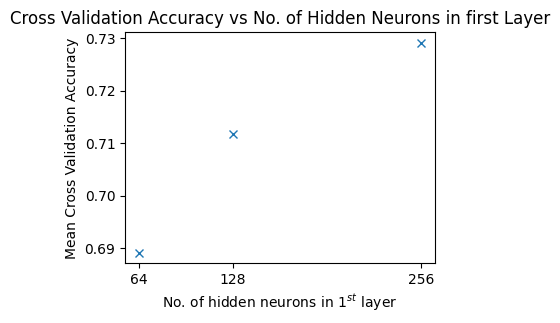

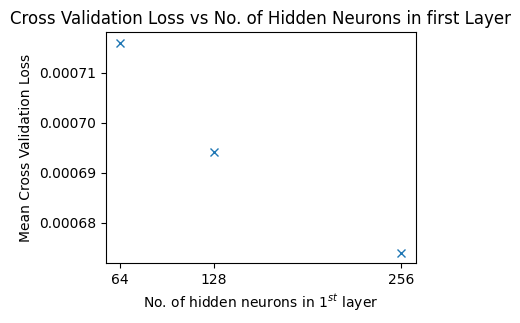

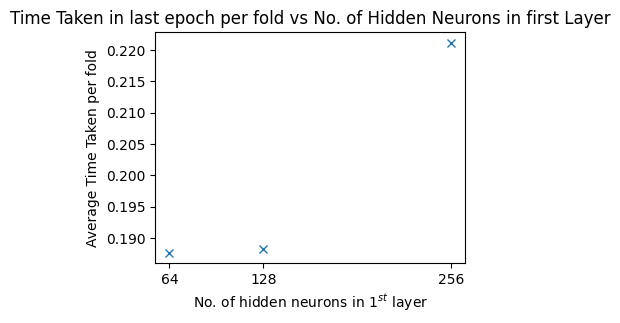

In [6]:
from re import search
# YOUR CODE HERE
def scatterplot(x, y, title):
    plt.figure(figsize=(4,3))
    plt.plot(x, y, marker='x', linestyle='None')
    plt.xticks(x)
    plt.xlabel('No. of hidden neurons in $1^s$$^t$ layer')
    if "Accuracy" in title:
        plt.ylabel('Mean Cross Validation Accuracy')
        plt.title("Cross Validation Accuracy vs No. of Hidden Neurons in first Layer")
    elif "Loss" in title:
        plt.ylabel('Mean Cross Validation Loss')
        plt.title("Cross Validation Loss vs No. of Hidden Neurons in first Layer")
    else:
        plt.ylabel('Average Time Taken per fold')
        plt.title("Time Taken in last epoch per fold vs No. of Hidden Neurons in first Layer")
    plt.show()

train_acc, train_loss, test_acc, test_loss = [], [], [], []
timing = []

for key, val in cross_validation_accuracies['train_acc'].items():
    # train_acc.append(val['last_epoch'])
    train_acc.append(val['data'])
for key, val in cross_validation_accuracies['train_loss'].items():
    # train_loss.append(val['last_epoch'])
    train_loss.append(val['data'])
for key, val in cross_validation_accuracies['test_acc'].items():
    # test_acc = val['data']
    test_acc.append(val['data'])
for key, val in cross_validation_accuracies['test_loss'].items():
    # test_loss = val['data']
    test_loss.append(val['data'])
for key, val in cross_validation_times.items():
    # timing = val['data']
    timing.append(val['data'])

# print(f"Test Acc: {len(test_acc)}")
def get_mean(array_of_matrix):
    test_mean = []
    for each_batch in range(len(array_of_matrix)):
        mean_per_fold = []
        for fold in array_of_matrix[each_batch]:
            mean_per_fold.append(fold[-1])
        # print(f"mean per fold: {mean_per_fold}")
        test_mean.append(np.mean(mean_per_fold))
        # print(f"test_mean: {test_mean[-1]:.4f}")
    return test_mean

test_acc_ = get_mean(test_acc)
test_loss_ = get_mean(test_loss)
time_taken_ = get_mean(timing)



scatterplot(num_neurons, test_acc_, "Accuracy")
scatterplot(num_neurons, test_loss_, "Loss")
scatterplot(num_neurons, time_taken_, "Time Taken")



5. Select the optimal number of neurons for the hidden layer. State the rationale for your selection.

In [7]:
optimal_neurons = 256
reason = """
Optimal number of neurons seem to be at 256 neurons for the first layer.
I chose this value because it resulted it the highest test accuracy, as well as the lowest test loss.
Despite the average time taken across the folds in the last epoch being higher than the other experiments with different number of neurons,
I feel that the difference in time taken is almost negligible, with a maximum of 0.05 seconds difference.

From the plot about the training and testing cross validation accuracy,
we can also see that the model doesnt seem to have overfitted,
with the values converging similarly across all folds.
"""
# YOUR CODE HERE

no_features = 77
no_labels = 2

processed_X_train, processed_X_test = preprocess_dataset(X_train, X_test)
model = MLP(no_features, optimal_neurons, no_labels)

train_acc_, train_loss_, test_acc_, test_loss_, time_taken_ = train(
    model, processed_X_train, y_train, processed_X_test, y_test, 1024
)

		Train Acc: 0.9169	Test Acc: 0.7496	Train Loss: 0.0004	Test Loss: 0.0006	Time: 0.4552


6. Plot the train and test accuracies against training epochs with the optimal number of neurons using a line plot.

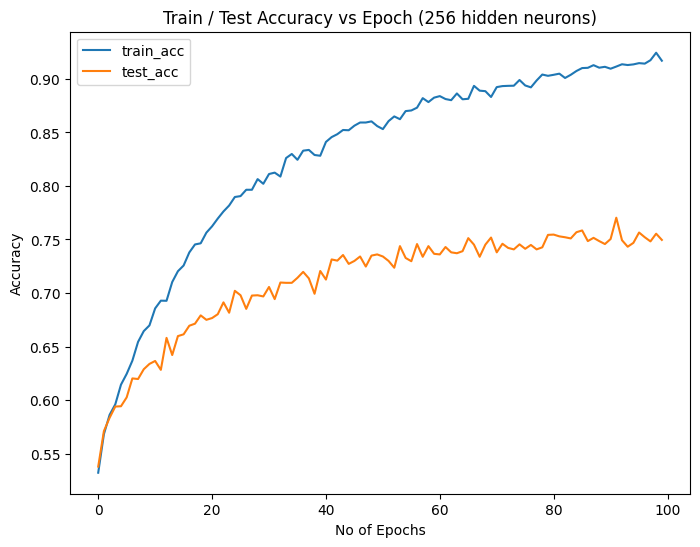

In [8]:
# YOUR CODE HERE
def lineplot(no_epochs, train_acc, test_acc, neurons):
    plt.figure(figsize=(8, 6))
    plt.plot(range(no_epochs), train_acc, label=f'train_acc')
    plt.plot(range(no_epochs), test_acc, label=f'test_acc')
    plt.xlabel('No of Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'Train / Test Accuracy vs Epoch ({neurons} hidden neurons)')
    plt.legend()
    plt.show()

# def get_max(test_acc):
#     print(f"test_acc: {test_acc}")
#     maxval = np.argmax(test_acc)
#     print(f"maxval: {maxval}")
#     return maxval

# train_acc_data, train_loss_data, test_acc_data, test_loss_data = [], [], [], []
# idx = get_max(test_acc_)
lineplot(100, train_acc_, test_acc_, optimal_neurons)